# Classifier Evaluation


This notebook assumes precomputed ground truth maps either as pickles or csv files. The ground truth is expected to include the following classes:
1. bacground
2. sand
3. construction sand
4. pebbles


In [13]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle
from os.path import exists
from matplotlib import cm
import os

In [14]:
# Setup required variables

class_strings = {}

class_strings[1] = "red"
class_strings[2] = "green"
class_strings[3] = "blue"
class_strings[4] = "yellow"

classes = [1,2,3,4]

empty = [0,0,0,0]

data_path_seg = "processed-data/tertiary-capture/radiance/2022_11_16/33-2nd"
data_path_class = "processed-data/tertiary-capture/reflectance/2022_11_16/33-2nd"


## Generate Ground Truth Maps

This only needs to be run once.

In [7]:
dir_cont = os.listdir(data_path_seg)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

print(data_cubes)

['2022_11_16-04_01_51.nc', '2022_11_16-04_11_30.nc', '2022_11_16-04_10_05.nc', '2022_11_16-04_13_22.nc', '2022_11_16-04_03_31.nc', '2022_11_16-04_12_37.nc', '2022_11_16-04_04_28.nc', '2022_11_16-04_02_46.nc', '2022_11_16-04_08_52.nc', '2022_11_16-04_10_54.nc']


KeyboardInterrupt: Interrupted by user

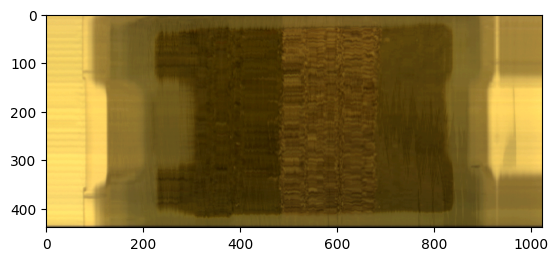

In [4]:
ground_truths = []

def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

def on_click(event,x,y,flags,params):
    global marks_updated

    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(marker_img,(x,y),10,(current_marker),-1) 
        
        cv.circle(img_copy,(x,y),10,colors[current_marker],-1)

        marks_updated = True 
        
def process_into_rgb(path):
    ds = nc.Dataset(fn)
    dc = np.array(ds['datacube'])
    binned_wavelengths = np.array(ds['wavelength'])
    image = np.zeros((dc.shape[1],dc.shape[2],3), np.uint8)

    red_wavelength = 620
    green_wavelength = 560
    blue_wavelength = 470

    red_layer = dc[np.argmin(np.abs(binned_wavelengths-red_wavelength)),:,:]  
    green_layer = dc[np.argmin(np.abs(binned_wavelengths-green_wavelength)),:,:] 
    blue_layer = dc[np.argmin(np.abs(binned_wavelengths-blue_wavelength)),:,:] 

    image[:,:,0] = red_layer
    image[:,:,1] = green_layer
    image[:,:,2] = blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    vmax = np.nanpercentile(image, 98)
    vmin = np.nanpercentile(image, 2)
    image = ((image.astype("f8") - vmin) / (vmax - vmin)).astype("f4")
    image = np.minimum(np.maximum(image, 0), 1)

    image *= 255
    image = image.astype(np.uint8)

    plt.imshow(image)
    
    return image
        
for file in data_cubes:
    # get files for this work
    fn = data_path_seg + '/' + file
    gnd_t_fn = data_path_class + "/" + file.split('.')[0] + ".pkl"
    
    image = process_into_rgb(fn)
    
    # convert from rgb to bgr
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

    img_copy=np.copy(image)
    marker_img=np.zeros(image.shape[:2],dtype=np.int32)
    segments = np.zeros(image.shape,dtype=np.uint8)
    ground_truth = np.zeros(image.shape[:2],dtype=np.uint8)

    cm.tab10(0)

    colors = []
    for i in range(10):
        colors.append(create_rgb(i))
    colors[1]=(0,0,0)

    n_marker = 9
    current_marker = 1
    marks_updated = False

    # create display window
    cv.namedWindow('Image')
    cv.setMouseCallback('Image', on_click)

    while True:

        cv.imshow('Watershed segments',segments)
        cv.imshow('Image',img_copy)

        k = cv.waitKey(1)

        # jump out of loop and close all windows with ESC
        if k == 27:
            break

        # clear the images with c
        elif k == ord('c'):
            img_copy = image.copy()
            marker_img = np.zeros(image.shape[:2],dtype = np.int32)
            segments = np.zeros(image.shape,dtype = np.uint8) 

        # update the colour choice, keys [1-9] 
        elif k > 0 and chr(k).isdigit():
            current_marker = int(chr(k))

        # update the watershed fill based on the marks
        if marks_updated:
            marker_img_copy = marker_img.copy()
            cv.watershed(image,marker_img_copy)
            segments = np.zeros(image.shape,dtype = np.uint8)

            for color_ind in range(n_marker):
                segments[marker_img_copy == (color_ind)] = colors[color_ind]
                ground_truth[marker_img_copy == (color_ind)] = color_ind

    # close all windows
    cv.destroyAllWindows()

    # save ground truth for future use
    with open(gnd_t_fn, 'wb') as out_file:
        pickle.dump(ground_truth, out_file)
        
    if input("Do you wish to continue? [Y/n]") == "n":
        break;

## Complete CLassification and Evaluation

In [15]:
dir_cont = os.listdir(data_path_class)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

print(data_cubes)

['2022_11_16-04_01_51.nc', '2022_11_16-04_11_30.nc', '2022_11_16-04_10_05.nc', '2022_11_16-04_13_22.nc', '2022_11_16-04_03_31.nc', '2022_11_16-04_12_37.nc', '2022_11_16-04_04_28.nc', '2022_11_16-04_02_46.nc', '2022_11_16-04_08_52.nc', '2022_11_16-04_10_54.nc']


In [16]:
num = 0;
classifier_created = False
classifications = []

for file in data_cubes:
    num += 1
    print("Processing file " + str(num) + ": " + file)
    
    # get files for this work
    fn = data_path_class + '/' + file
    png_fn = fn.split('.')[0] + ".png"
    gnd_t_fn = fn.split('.')[0] + ".pkl"
    
    # read the netCDF file
    ds = nc.Dataset(fn)
    
    # extract the datacube from the dataset
    dc = np.array(ds['datacube'])
    
    # Data needs to be x, y, bands instead of bands, x, y.
    data = dc.transpose(1,2,0)
    
    # Read in ground truth
    with open(gnd_t_fn, 'rb') as in_file:
        ground_truth = pickle.load(in_file)
    
    # Create and run GMLC
    # create the classes to train the classifier
    training_classes = create_training_classes(data, ground_truth)
    
    # The classifier should only be created once, then used for all images.
    if classifier_created == False:
        classifier_created = True
        # create an instance of the classifier
        classifier = GaussianClassifier(training_classes)
    
    # classifier the hsi image
    classified_data = classifier.classify_image(data)
    
    # view the classified image
    v = imshow(classes=classified_data)
    classifications.append(classified_data)
    
    # view the ground truth
    v = imshow(classes=ground_truth)
    ground_truths.append(ground_truth)

Processing file 1: 2022_11_16-04_01_51.nc
Processing...  0.0%

AttributeError: 'GaussianClassifier' object has no attribute 'classes'

In [20]:
# If the classifications and ground_truths have been previously computed and saved, they can be read in here

run = True

in_path = "processed-data/tertiary-capture/"
version = "-33-2nd"

if run:        
    with open(in_path + 'classifications'+version+'.pkl', 'rb') as out_file:
        classifications = pickle.load(out_file)

    with open(in_path + 'ground_truths'+version+'.pkl', 'rb') as out_file:
        ground_truths = pickle.load(out_file)

In [21]:
y_true = []
y_iou = []

print("Evaluating Classifications...")

# Evaluate the classifications
for i in range(len(classifications)):
    print("Evaluating classification " + str(i) + "...")
      
    classified_data = classifications[i]
    ground_truth = ground_truths[i]
    
    # setup IoU data
    tp = empty.copy()
    fp = empty.copy()
    tn = empty.copy()
    fn = empty.copy()
    
    for i in classes:
        y_true.append(i)

        mask = ground_truth.copy()
        
        for x in range(classified_data.shape[0]-1):
            for y in range(classified_data.shape[1]-1):
                # create mask
                mask[x,y] = 1 if ground_truth[x,y] == i else 0
                
                # calculate classification metrics
                if ground_truth[x,y] == classified_data[x,y] == i: # true positive, both gt and classified classes match
                    tp[i-1] += 1
                elif ground_truth[x,y] == i and classified_data[x,y] != i: # false negative, gt and classified should match but classified doesn't
                    fn[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] == i: # false positive, gt is not the class, but classified is
                    fp[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] != i: # true negative the ground truth and the classified don't match
                    tn[i-1] += 1
                
        # Calculate IoU value for the class.
        y_iou.append(tp[i-1]/(tp[i-1]+fp[i-1]+fn[i-1]))
        

Evaluating Classifications...
Evaluating classification 0...
Evaluating classification 1...
Evaluating classification 2...
Evaluating classification 3...
Evaluating classification 4...
Evaluating classification 5...
Evaluating classification 6...
Evaluating classification 7...
Evaluating classification 8...
Evaluating classification 9...


In [22]:
y_pred = []

for i in range(len(classifications)):
    
    print("Evaluating classification " + str(i) + "...")
      
    classified_data = classifications[i]
    mask = ground_truths[i]
    
    for j in classes:
        if y_iou[i] > 0.8:
            # this is acceptable overlap
            y_pred.append(j)
        else:
            # this is not correct but for now, fill with most common class in masked region.
            cls_img = classified_data * mask

            line = cls_img.copy().reshape(cls_img.shape[0]*cls_img.shape[1])

            occurances = np.bincount(line)

            # i is the current class so remove it
            occurances = np.delete(occurances,j)

            # 0 will always be the most common because of the mask so delete it.
            occurances = np.delete(occurances,0)

            y_pred.append(np.argmax(occurances)+1)  

Evaluating classification 0...
Evaluating classification 1...
Evaluating classification 2...
Evaluating classification 3...
Evaluating classification 4...
Evaluating classification 5...
Evaluating classification 6...
Evaluating classification 7...
Evaluating classification 8...
Evaluating classification 9...


### View results

note, due to the inaccurate ground truth, there are many errors in classification (technically) as the background is being *correctly* classified as what it should where it hasn't been labelled properly in the ground truth.

[useful](https://towardsdatascience.com/guide-to-confusion-matrices-classification-performance-metrics-a0ebfc08408e)

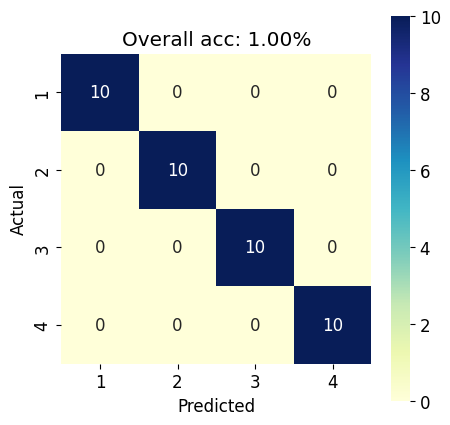

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

class_labels = ['background', 'construction sand', 'pebbles', 'beach sand']
class_labels = classes
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y_true, y_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=10,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y_true, y_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

In [38]:
# Save the classification and ground truth arrays for reuse.

out_path = "processed-data/tertiary-capture/"

with open(out_path + 'classifications.pkl', 'wb') as out_file:
    pickle.dump(classifications, out_file)

with open(out_path + 'ground_truths.pkl', 'wb') as out_file:
    pickle.dump(ground_truths, out_file)

In [ ]:
cv.destroyAllWindows()

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


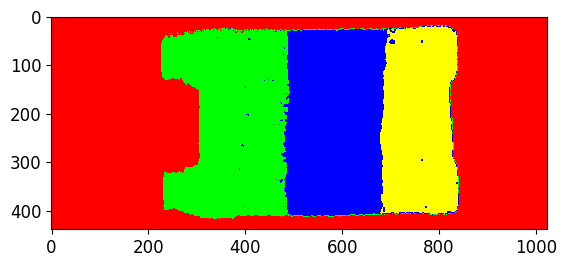

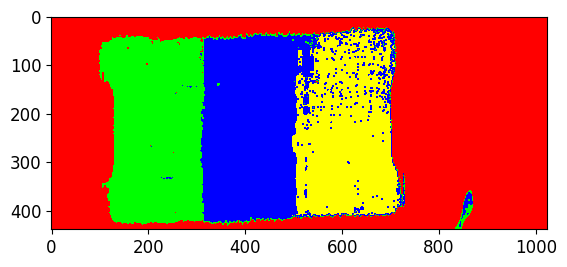

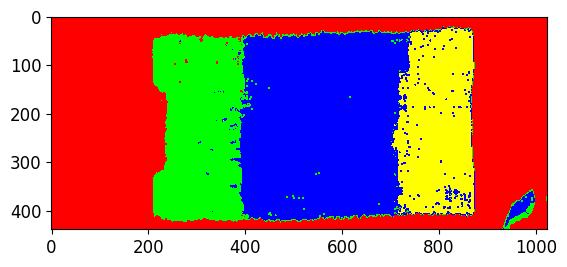

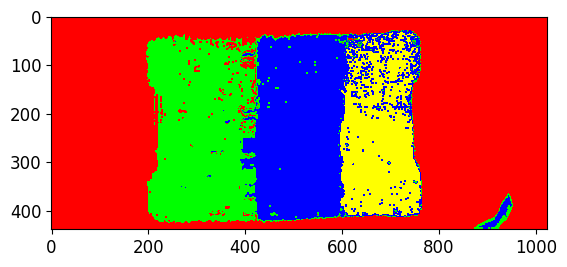

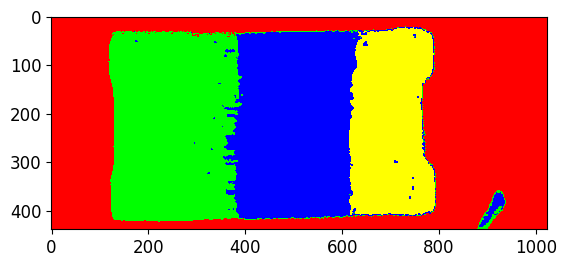

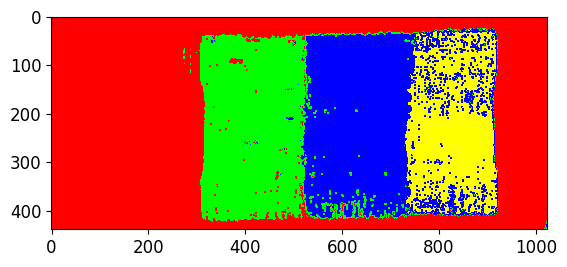

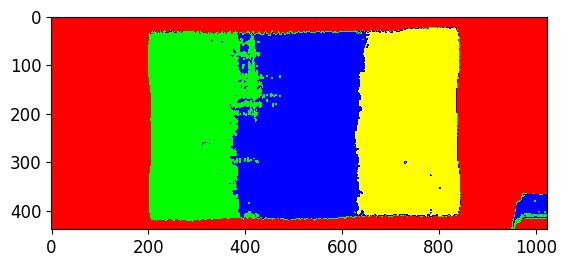

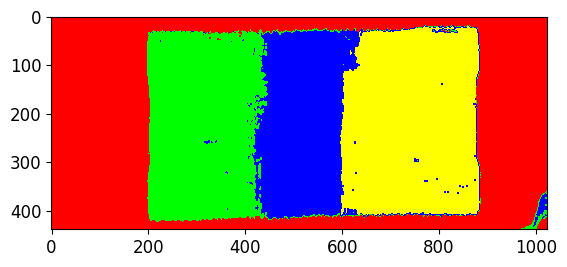

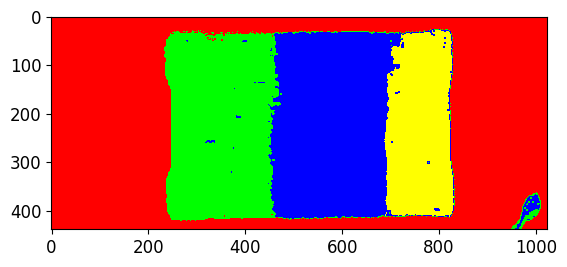

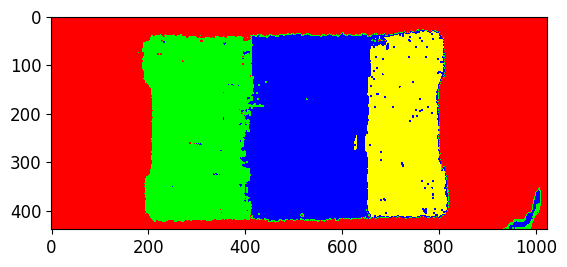

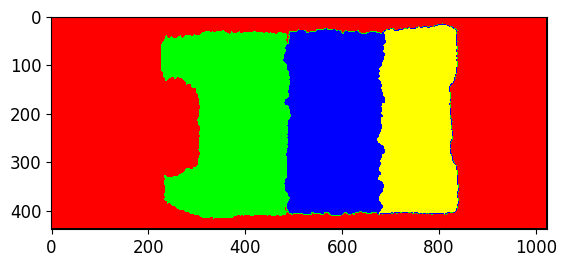

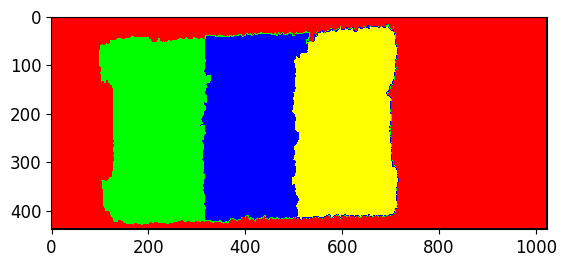

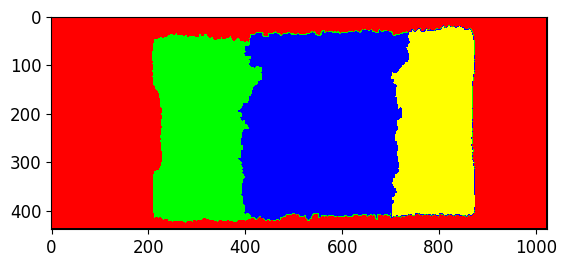

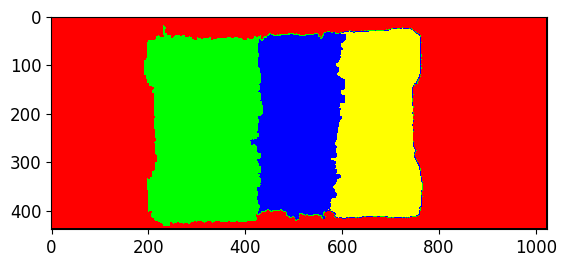

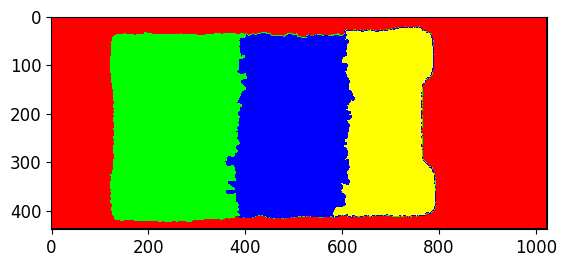

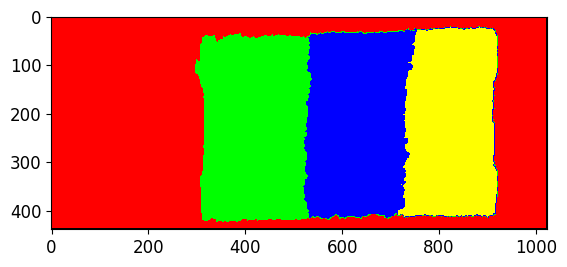

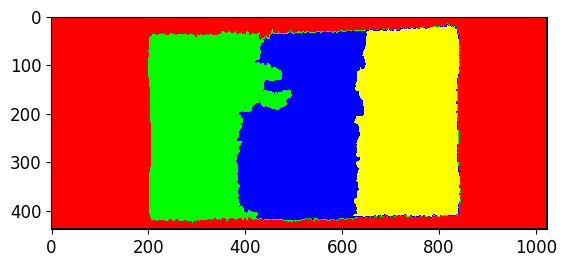

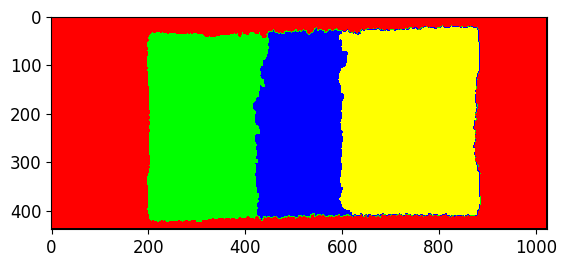

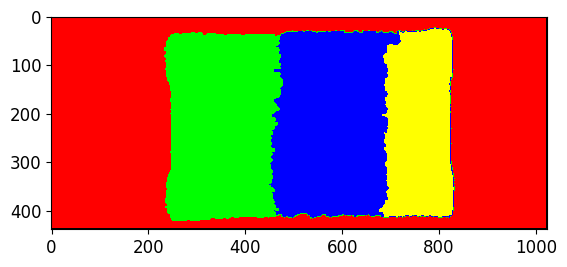

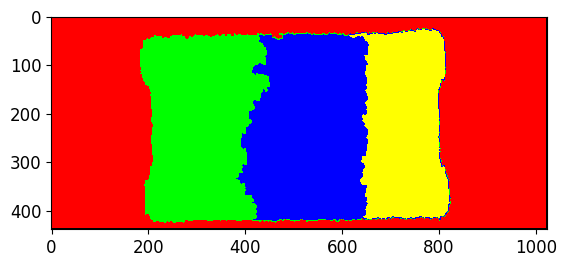

In [24]:
# display saved data

for image in classifications:
    v = imshow(classes=image)
    

for image in ground_truths:
    v = imshow(classes=image)